In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

## Helpers

In [2]:
def plot_vectors(vectors=[(0, 0, 1, 2),(0, 0, 3, 1)], 
                 texts=[r'$\vec{a}$', r'$\vec{b}$', 'power vec', 'power vec2'], 
                 texts_locs=[(0.5, 0.7), (0.2, 0.8), (0.7, 0.5),  (0.5, 0.5)], text_size=18, 
                 colors=["#2EBCE7","#00E64E", "purple", 'orange'],   
                 xlim=(-1, 3), ylim=(-1,3), x_label='x', y_label='y', 
                 scale=1, scale_units='xy'):
    fig, ax =plt.subplots(figsize=(6,6))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    for i, vec in enumerate(vectors):
        ax.quiver(*vec, color=colors[i], angles='xy', scale_units=scale_units, scale=scale)
        plt.text(*texts_locs[i], texts[i], color=colors[i], size=text_size)

    # draw axes
    plt.axhline(0, c='#d6d6d6', zorder=0)
    plt.axvline(0, c='#d6d6d6', zorder=0)

    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    return ax

## SVD methods, beer example

#### Beer dataset

Data is available from here: https://www.kaggle.com/dongeorge/beer-consumption-sao-paulo

In [33]:
df=pd.read_csv('Consumo_cerveja.csv')
df.shape

(941, 7)

In [34]:
df = df.dropna()

In [35]:
df['Temperatura Maxima (C)'] = df['Temperatura Maxima (C)'].apply(lambda x: float(x.replace(',','.')))

dtype('O')

In [36]:
def plot_beer(x, y, x_label="Maximal temperature ($\degree$C)", y_label="Consuption (liters)", 
              alpha=0.3, draw_axes=False):
    plt.scatter(x, y, alpha=alpha)

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Assure that ticks are displayed with a specific step
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    
    if draw_axes:
        # draw axes
        plt.axhline(0, c='#d6d6d6', zorder=0)
        plt.axvline(0, c='#d6d6d6', zorder=0)

    # assure x and y axis have the same scale
    plt.axis('equal')
    plt.show()

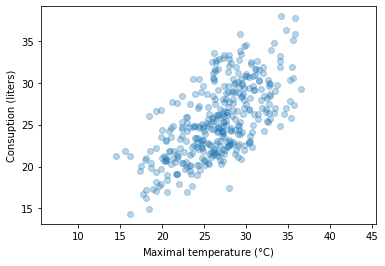

In [37]:
plot_beer(df['Temperatura Maxima (C)'],
          df['Consumo de cerveja (litros)'])

#### Make datasets

In [38]:
X = np.array([df['Temperatura Maxima (C)'],
              df['Consumo de cerveja (litros)']]).T

#### Covariance matrix

In [39]:
C = np.cov(X, rowvar=False)
C

array([[18.63964745, 12.20609082],
       [12.20609082, 19.35245652]])

In [40]:
#for easier plotting calculate mean centered data
X_norm=X.copy()
X_norm -= X.mean(axis=0)

## Version 1  - power iteration

In [41]:
#source http://mlwiki.org/index.php/Power_Iteration
def eigenvalue(A, v):
    val = A @ v / v
    return val[0]

def svd_power_iteration(A):
    n, d = A.shape

    v = np.ones(d) / np.sqrt(d)
    ev = eigenvalue(A, v)

    while True:
        Av = A @ v
        v_new = Av / np.linalg.norm(Av)
        ev_new = eigenvalue(A, v_new)
        if np.abs(ev - ev_new) < 0.01:
            break

        v = v_new
        ev = ev_new

    return ev_new, v_new

In [42]:
eigen_value, eigen_vec = svd_power_iteration(C)
eigen_value

31.206525014487084

In [43]:
eigen_vec

array([0.69673479, 0.71732882])

In [44]:
#compare to numpy implementation
u, s, v=np.linalg.svd(C, 1)

In [13]:
u # first eigenvector matches, we can ignore the signs as they are still same eigenvector

array([[-0.69671139, -0.71735154],
       [-0.71735154,  0.69671139]])

In [14]:
s #numpy has second eigenvalue also

array([31.20734501,  6.78475896])

In [45]:
v

array([[-0.69671139, -0.71735154],
       [-0.71735154,  0.69671139]])

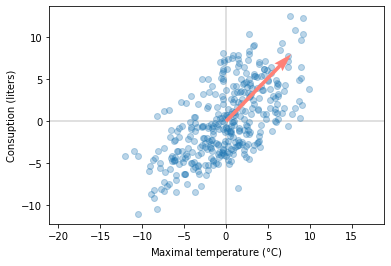

In [46]:
#lets plot dominant eigenvector
def plot_eigenvectors(eigen_vecs, eigen_values, colors=["#FF8177", "orange"]):
    for i, eigen_vec in enumerate(eigen_vecs):
        plt.quiver(0, 0,
           2 * np.sqrt(eigen_values[i]) * eigen_vec[0], 2 * np.sqrt(eigen_values[i]) * eigen_vec[1],
           color=colors[i], angles="xy", scale_units="xy", scale=1,
           zorder=2, width=0.011)

plot_eigenvectors([eigen_vec], [eigen_value], colors=["#FF8177", "orange"])
plot_beer(X_norm[:, 0], X_norm[:, 1], draw_axes=True)

## Version 2  - svd for n singular values

In [47]:
#https://jeremykun.com/2016/05/16/singular-value-decomposition-part-2-theorem-proof-algorithm/
#https://github.com/j2kun/svd/blob/main/svd.py
def eigenvalue(A, v):
    val = A @ v / v
    return val[0]

def svd_dominant_eigen(A, epsilon=0.01):
    """returns dominant eigenvalue and dominant eigenvector of matrix A"""
    n, m = A.shape
    k=min(n,m)
    v = np.ones(k) / np.sqrt(k)
    if n > m:
        A = A.T @ A
    elif n < m:
        A = A @ A.T
    
    ev = eigenvalue(A, v)

    while True:
        Av = A@ v
        v_new = Av / np.linalg.norm(Av)
        ev_new = eigenvalue(A, v_new)
        if np.abs(ev - ev_new) < epsilon:
            break

        v = v_new
        ev = ev_new

    return ev_new, v_new

def svd(A, k=None, epsilon=1e-10):
    """returns k dominant eigenvalues and eigenvectors of matrix A"""
    A = np.array(A, dtype=float)
    n, m = A.shape
        
    svd_so_far = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrix_for_1d = A.copy()

        for singular_value, u, v in svd_so_far[:i]:
            matrix_for_1d -= singular_value * np.outer(u, v)

        if n > m:
            _, v = svd_dominant_eigen(matrix_for_1d, epsilon=epsilon)  # next singular vector
            u_unnormalized = A @ v
            sigma = np.linalg.norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            _, u = svd_dominant_eigen(matrix_for_1d, epsilon=epsilon)  # next singular vector
            v_unnormalized = A.T @ u
            sigma = np.linalg.norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svd_so_far.append((sigma, u, v))

    singular_values, us, vs = [np.array(x) for x in zip(*svd_so_far)]
    return singular_values, us.T, vs

In [48]:
eigen_values, eigen_vecs, _ = svd(C)

In [49]:
eigen_values

array([31.20734501,  6.78475896])

In [50]:
eigen_vecs

array([[ 0.69671139,  0.71735154],
       [ 0.71735154, -0.69671139]])

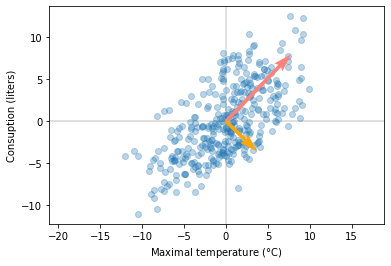

In [51]:
plot_eigenvectors(eigen_vecs, eigen_values, colors=["#FF8177", "orange"])
plot_beer(X_norm[:, 0], X_norm[:, 1], draw_axes=True)

In [22]:
#more columns than rows
mat=np.array([[1,2,3],
            [4,5,6]])
mat

array([[1, 2, 3],
       [4, 5, 6]])

In [23]:
u, s, v=np.linalg.svd(mat, full_matrices=False)

In [24]:
values, left_s, rigth_s=svd(mat)

In [25]:
u

array([[-0.3863177 , -0.92236578],
       [-0.92236578,  0.3863177 ]])

In [26]:
left_s

array([[ 0.3863177 ,  0.92236578],
       [ 0.92236578, -0.3863177 ]])

In [27]:
np.allclose(np.absolute(u), np.absolute(left_s))

True

In [28]:
np.allclose(s, values)

True

In [29]:
np.allclose(np.absolute(v), np.absolute(rigth_s))

True

In [30]:
#more rows than columns
mat2=np.array([[1,2,3],
            [4,5,6],
              [6,1,9],
              [3,2,3]])
mat2

array([[1, 2, 3],
       [4, 5, 6],
       [6, 1, 9],
       [3, 2, 3]])

In [31]:
u_mat2, s_mat2, v_mat2 = np.linalg.svd(mat2, full_matrices=False)

In [32]:
values_mat2, left_s_mat2, right_s_mat2=svd(mat2)

In [33]:
np.allclose(np.absolute(u_mat2), np.absolute(left_s_mat2))

True

In [34]:
np.allclose(s_mat2, values_mat2)

True

In [35]:
np.allclose(np.absolute(v_mat2), np.absolute(right_s_mat2))

True

## Simultaneous power iteration /Orthogonal Iteration / block version of the Power Method

In [36]:
def svd_simultaneous_power_iteration(A, k, epsilon=0.00001):
    #source http://mlwiki.org/index.php/Power_Iteration
    #adjusted to work with n<m and n>m matrices
    n_orig, m_orig = A.shape
    if k is None:
        k=min(n_orig,m_orig)
        
    A_orig=A.copy()
    if n_orig > m_orig:
        A = A.T @ A
        n, m = A.shape
    elif n_orig < m_orig:
        A = A @ A.T
        n, m = A.shape
    else:
        n,m=n_orig, m_orig
        
    Q = np.random.rand(n, k)
    Q, _ = np.linalg.qr(Q)
    Q_prev = Q
 
    for i in range(1000):
        Z = A @ Q
        Q, R = np.linalg.qr(Z)
        # can use other stopping criteria as well 
        err = ((Q - Q_prev) ** 2).sum()
        Q_prev = Q
        if err < epsilon:
            break
            
    singular_values=np.sqrt(np.diag(R))    
    if n_orig < m_orig: 
        left_vecs=Q.T
        #use property Values @ V = U.T@A => V=inv(Values)@U.T@A
        right_vecs=np.linalg.inv(np.diag(singular_values))@left_vecs.T@A_orig
    elif n_orig==m_orig:
        left_vecs=Q.T
        right_vecs=left_vecs
        singular_values=np.square(singular_values)
    else:
        right_vecs=Q.T
        #use property Values @ V = U.T@A => U=A@V@inv(Values)
        left_vecs=A_orig@ right_vecs.T @np.linalg.inv(np.diag(singular_values))

    return left_vecs, singular_values, right_vecs

In [37]:
left_vecs, singular_values, right_vecs = svd_simultaneous_power_iteration(C, 2)

In [38]:
singular_values

array([31.20730124,  6.78476848])

In [39]:
left_vecs

array([[-0.69644374, -0.71761139],
       [-0.71761139,  0.69644374]])

In [40]:
right_vecs

array([[-0.69644374, -0.71761139],
       [-0.71761139,  0.69644374]])

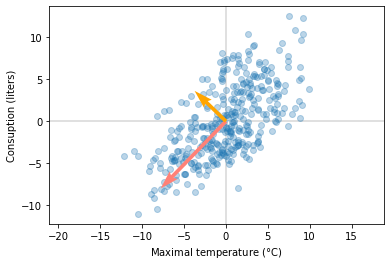

In [41]:
plot_eigenvectors(left_vecs, singular_values, colors=["#FF8177", "orange"])
plot_beer(X_norm[:, 0], X_norm[:, 1], draw_axes=True)

In [42]:
u, s,v = np.linalg.svd(C)
np.allclose(np.absolute(left_vecs), np.absolute(u), atol=0.01)

True

In [43]:
np.allclose(np.absolute(right_vecs), np.absolute(v), atol=0.01)

True

In [44]:
np.allclose(singular_values, s, atol=0.01)

True

In [45]:
# matrix which has more columns than rows
left_mat, values_mat, right_mat=svd_simultaneous_power_iteration(mat, 2)

In [46]:
u, s, v =np.linalg.svd(mat, full_matrices=False)

In [47]:
np.allclose(np.absolute(left_mat), np.absolute(u), atol=0.01)

True

In [48]:
np.allclose(np.absolute(right_mat), np.absolute(v), atol=0.01)

True

In [49]:
np.allclose(values_mat, s, atol=0.01)

True

In [50]:
# matrix which has more rows than columns

In [51]:
left_mat2, values_mat2,right_mat2=svd_simultaneous_power_iteration(mat2, 3)
u, s, v =np.linalg.svd(mat2, full_matrices=False)

In [52]:
np.allclose(np.absolute(left_mat2), np.absolute(u), atol=0.01)

True

In [53]:
np.allclose(np.absolute(right_mat2), np.absolute(v), atol=0.01)

True

In [54]:
np.allclose(values_mat2, s, atol=0.01)

True